In [1]:
! git clone https://github.com/matuira/neural-collaborative-filtering.git

In [174]:
%pip install tensorboardX

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [204]:
import math
import pandas as pd
import numpy as np
import torch
import random
import os
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt

In [205]:
# metrics

class MetronAtK(object):
    def __init__(self, top_k):
        self._top_k = top_k
        self._subjects = None  # Subjects which we ran evaluation on

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, top_k):
        self._top_k = top_k

    @property
    def subjects(self):
        return self._subjects

    @subjects.setter
    def subjects(self, subjects):
        """
        args:
            subjects: list, [test_users, test_items, test_scores, negative users, negative items, negative scores]
        """
        assert isinstance(subjects, list)
        test_users, test_items, test_scores = subjects[0], subjects[1], subjects[2]
        neg_users, neg_items, neg_scores = subjects[3], subjects[4], subjects[5]
        # the golden set
        test = pd.DataFrame({'user': test_users,
                             'test_item': test_items,
                             'test_score': test_scores})
        # the full set
        full = pd.DataFrame({'user': neg_users + test_users,
                            'item': neg_items + test_items,
                            'score': neg_scores + test_scores})
        full = pd.merge(full, test, on=['user'], how='left')
        # rank the items according to the scores for each user
        full['rank'] = full.groupby('user')['score'].rank(method='first', ascending=False)
        full.sort_values(['user', 'rank'], inplace=True)
        self._subjects = full

    def cal_hit_ratio(self):
        """Hit Ratio @ top_K"""
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank']<=top_k]
        test_in_top_k =top_k[top_k['test_item'] == top_k['item']]  # golden items hit in the top_K items
        return len(test_in_top_k) * 1.0 / full['user'].nunique()

    def cal_ndcg(self):
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank']<=top_k]
        test_in_top_k =top_k[top_k['test_item'] == top_k['item']]
        test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) # the rank starts from 1
        return test_in_top_k['ndcg'].sum() * 1.0 / full['user'].nunique()

In [206]:
# utils

def save_checkpoint(model, model_dir):
    torch.save(model.state_dict(), model_dir)


def resume_checkpoint(model, model_dir, device_id):
    state_dict = torch.load(model_dir,
                            map_location=lambda storage, loc: storage.cuda(device=device_id))  # ensure all storage are on gpu
    model.load_state_dict(state_dict)


# Hyper params
def use_cuda(enabled, device_id=0):
    if enabled:
        assert torch.cuda.is_available(), 'CUDA is not available'
        torch.cuda.set_device(device_id)


def use_optimizer(network, params):
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params['sgd_lr'],
                                    momentum=params['sgd_momentum'],
                                    weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(), 
                                                          lr=params['adam_lr'],
                                                          weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params['rmsprop_lr'],
                                        alpha=params['rmsprop_alpha'],
                                        momentum=params['rmsprop_momentum'])
    return optimizer

In [247]:
# engine

class Engine(object):
    """Meta Engine for training & evaluating NCF model

    Note: Subclass should implement self.model !
    """

    def __init__(self, config):
        self.config = config  # model configuration
        self._metron = MetronAtK(top_k=10)
        self._writer = SummaryWriter(log_dir='runs/{}'.format(config['alias']))  # tensorboard writer
        self._writer.add_text('config', str(config), 0)
        self.opt = use_optimizer(self.model, config)
        # explicit feedback
        # self.crit = torch.nn.MSELoss()
        # implicit feedback
        self.crit = torch.nn.BCELoss()

    def train_single_batch(self, users, items, ratings):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        if self.config['use_cuda'] is True:
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()
        self.opt.zero_grad()
        ratings_pred = self.model(users, items)
        loss = self.crit(ratings_pred.view(-1), ratings)
        loss.backward()
        self.opt.step()
        loss = loss.item()
        return loss

    def train_an_epoch(self, train_loader, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.train()
        total_loss = 0
        for batch_id, batch in enumerate(train_loader):
            assert isinstance(batch[0], torch.LongTensor)
            user, item, rating = batch[0], batch[1], batch[2]
            rating = rating.float()
            loss = self.train_single_batch(user, item, rating)
            print('[Training Epoch {}] Batch {}, Loss {}'.format(epoch_id, batch_id, loss))
            total_loss += loss
        self._writer.add_scalar('model/loss', total_loss, epoch_id)

    def evaluate(self, evaluate_data, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.eval()
        with torch.no_grad():
            test_users, test_items = evaluate_data[0], evaluate_data[1]
            negative_users, negative_items = evaluate_data[2], evaluate_data[3]
            if self.config['use_cuda'] is True:
                test_users = test_users.cuda()
                test_items = test_items.cuda()
                negative_users = negative_users.cuda()
                negative_items = negative_items.cuda()
            test_scores = self.model(test_users, test_items)
            negative_scores = self.model(negative_users, negative_items)
            if self.config['use_cuda'] is True:
                test_users = test_users.cpu()
                test_items = test_items.cpu()
                test_scores = test_scores.cpu()
                negative_users = negative_users.cpu()
                negative_items = negative_items.cpu()
                negative_scores = negative_scores.cpu()
            self._metron.subjects = [test_users.data.view(-1).tolist(),
                                 test_items.data.view(-1).tolist(),
                                 test_scores.data.view(-1).tolist(),
                                 negative_users.data.view(-1).tolist(),
                                 negative_items.data.view(-1).tolist(),
                                 negative_scores.data.view(-1).tolist()]
        hit_ratio, ndcg = self._metron.cal_hit_ratio(), self._metron.cal_ndcg()
        self._writer.add_scalar('performance/HR', hit_ratio, epoch_id)
        self._writer.add_scalar('performance/NDCG', ndcg, epoch_id)
        print('[Evaluating Epoch {}] HR = {:.4f}, NDCG = {:.4f}'.format(epoch_id, hit_ratio, ndcg))
        return hit_ratio, ndcg

    def save(self, alias, epoch_id, hit_ratio, ndcg):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        model_dir = self.config['model_dir'].format(alias, epoch_id, hit_ratio, ndcg)
        save_checkpoint(self.model, model_dir)

In [286]:
# gmf

class GMF(torch.nn.Module):
    def __init__(self, config):
        super(GMF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.affine_output = torch.nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass


class GMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = GMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(GMFEngine, self).__init__(config)

In [289]:
# cosine

class COSINE(torch.nn.Module):
    def __init__(self, config):
        super(COSINE, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        self.logistic = torch.nn.Sigmoid()
        

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        cosine = self.cos(user_embedding, item_embedding)
        rating = self.logistic(cosine)
        return rating

    def init_weight(self):
        pass
    

class COSINEEngine(Engine):
    """Engine for training & evaluating COSINE model"""
    def __init__(self, config):
        self.model = COSINE(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(COSINEEngine, self).__init__(config)

In [354]:
# 1/euclidean_distance

class EUCLID(torch.nn.Module):
    def __init__(self, config):
        super(EUCLID, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        similarity = 1/torch.sqrt(torch.sum(torch.square(user_embedding-item_embedding)+1, dim=1))
        rating = self.logistic(similarity)
        return rating

    def init_weight(self):
        pass
    

class EUCLIDEngine(Engine):
    """Engine for training & evaluating EUCLID model"""
    def __init__(self, config):
        self.model = EUCLID(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(EUCLIDEngine, self).__init__(config)

In [346]:
# 1/manhattan_distance

class MANHAT(torch.nn.Module):
    def __init__(self, config):
        super(MANHAT, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        similarity = 1/torch.sum(torch.abs(user_embedding-item_embedding)+1, dim=1)
        rating = self.logistic(similarity)
        return rating

    def init_weight(self):
        pass
    

class MANHATEngine(Engine):
    """Engine for training & evaluating MANHAT model"""
    def __init__(self, config):
        self.model = MANHAT(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MANHATEngine, self).__init__(config)

In [317]:
# jaccard

class JACCARD(torch.nn.Module):
    def __init__(self, config):
        super(JACCARD, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        similarity = torch.sum(user_embedding*item_embedding,dim =1)/ \
                torch.sum(user_embedding+item_embedding-user_embedding*item_embedding,dim =1)
        rating = self.logistic(similarity)
        return similarity

    def init_weight(self):
        pass
    

class JACCARDEngine(Engine):
    """Engine for training & evaluating JACCARD model"""
    def __init__(self, config):
        self.model = JACCARD(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(JACCARDEngine, self).__init__(config)

In [342]:
# delta

class DELTA(torch.nn.Module):
    def __init__(self, config):
        super(DELTA, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        similarity = torch.sum(torch.abs(user_embedding-item_embedding),dim =1)
        rating = self.logistic(similarity)
        return rating

    def init_weight(self):
        pass
    

class DELTAEngine(Engine):
    """Engine for training & evaluating DELTA model"""
    def __init__(self, config):
        self.model = DELTA(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(DELTAEngine, self).__init__(config)

In [367]:
# pearson coeff

class PRS(torch.nn.Module):
    def __init__(self, config):
        super(PRS, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vx = user_embedding - torch.mean(user_embedding)
        vy = item_embedding - torch.mean(item_embedding)

        similarity = 1/(torch.sum(vx * vy, dim = 1) /torch.sum(vx ** 2, dim =1 )*torch.sqrt(torch.sum(vy ** 2, dim = 1))+1)
        
        rating = self.logistic(similarity)
        return rating

    def init_weight(self):
        pass
    

class PRSEngine(Engine):
    """Engine for training & evaluating PRS model"""
    def __init__(self, config):
        self.model = PRS(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(PRSEngine, self).__init__(config)

In [348]:
# aggregation

class AGG(torch.nn.Module):
    def __init__(self, config):
        super(AGG, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        self.logistic = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        euclid = 1/torch.sqrt(torch.sum(torch.square(user_embedding-item_embedding)+1, dim=1))
        cosine = (self.cos(user_embedding, item_embedding)+1)/2
        similarity = euclid * cosine
        rating = self.logistic(similarity)
        return rating

    def init_weight(self):
        pass
    

class AGGEngine(Engine):
    """Engine for training & evaluating AGG model"""
    def __init__(self, config):
        self.model = AGG(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(AGGEngine, self).__init__(config)

In [388]:
# mlp

class MLPPLUS(torch.nn.Module):
    def __init__(self, config):
        super(MLPPLUS, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = MLPPLUS(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mmlpplus'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPPLUSEngine(Engine):
    """Engine for training & evaluating MLPPLUS model"""
    def __init__(self, config):
        self.model = MLPPLUS(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPPLUSEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

In [ ]:
# mlp

class MLPPLUS(torch.nn.Module):
    def __init__(self, config):
        super(MLPPLUS, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = MLPPLUS(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mmlpplus'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPPLUSEngine(Engine):
    """Engine for training & evaluating MLPPLUS model"""
    def __init__(self, config):
        self.model = MLPPLUS(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPPLUSEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        cosine = self.cos(user_embedding, item_embedding)
        rating = self.logistic(cosine)
        return rating

In [485]:
# mlp plus cos

class MLPPLUSSIM(torch.nn.Module):
    def __init__(self, config):
        super(MLPPLUSSIM, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        self.embedding_user_cos = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_cos = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        self.embedding_user_euc = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_euc= torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf']+6, out_features=1)
        self.logistic = torch.nn.Sigmoid()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, user_indices, item_indices):
        dim1 = len(user_indices)
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
        user_embedding_cos = self.embedding_user_cos(user_indices)
        item_embedding_cos = self.embedding_item_cos(item_indices)
        user_embedding_euc = self.embedding_user_euc(user_indices)
        item_embedding_euc = self.embedding_item_euc(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
            
        cos_users = self.cos(user_embedding_cos, user_embedding_cos).reshape([dim1,1])
        cos_items = self.cos(item_embedding_cos , item_embedding_cos).reshape([dim1,1])
        cos_user_item = self.cos(user_embedding_cos, item_embedding_cos).reshape([dim1,1])
        
        euclid_users = (1/torch.sqrt(torch.sum(torch.square(user_embedding_euc-user_embedding_euc)+1, \
                                               dim=1))).reshape([dim1,1])
        euclid_items = (1/torch.sqrt(torch.sum(torch.square(item_embedding_euc-item_embedding_euc)+1, \
                                              dim=1))).reshape([dim1,1])
        euclid_user_item = (1/torch.sqrt(torch.sum(torch.square(user_embedding_euc-item_embedding_euc)+1, \
                                              dim=1))).reshape([dim1,1])
           
        vector = torch.cat([mlp_vector, mf_vector, cos_users, cos_items, cos_user_item, \
            euclid_users, euclid_items, euclid_user_item], dim=-1)
        
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating
    
    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = MLPPLUS(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mmlpplus'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPPLUSSIMEngine(Engine):
    """Engine for training & evaluating MLPPLUSSIM model"""
    def __init__(self, config):
        self.model = MLPPLUSSIM(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPPLUSSIMEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()
            

In [504]:
# mlp plus cos

class NEUMF(torch.nn.Module):
    def __init__(self, config):
        super(NEUMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
         
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, user_indices, item_indices):
        dim1 = len(user_indices)
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
    
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
            
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating
    
    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained NEUMF model"""
        config = self.config
        gmf_model = NEUMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mmlpplus'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class NEUMFEngine(Engine):
    """Engine for training & evaluating NEUMF model"""
    def __init__(self, config):
        self.model = NEUMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(NEUMFEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()
            

In [455]:
# mlp plus cos

class MLPPLUSSIM2(torch.nn.Module):
    def __init__(self, config):
        super(MLPPLUSSIM2, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        self.embedding_user_cos = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_cos = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        self.embedding_user_euc = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_euc= torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf']+12, out_features=1)
        self.logistic = torch.nn.Sigmoid()
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, user_indices, item_indices):
        dim1 = len(user_indices)
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
        user_embedding_cos = self.embedding_user_cos(user_indices)
        item_embedding_cos = self.embedding_item_cos(item_indices)
        user_embedding_euc = self.embedding_user_euc(user_indices)
        item_embedding_euc = self.embedding_item_euc(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
            
        cos_users = self.cos(user_embedding_cos, user_embedding_cos).reshape([dim1,1])
        cos_items = self.cos(item_embedding_cos , item_embedding_cos).reshape([dim1,1])
        cos_user_item = self.cos(user_embedding_cos, item_embedding_cos).reshape([dim1,1])
        
        euclid_users = (1/torch.sqrt(torch.sum(torch.square(user_embedding_euc-user_embedding_euc)+1, \
                                               dim=1))).reshape([dim1,1])
        euclid_items = (1/torch.sqrt(torch.sum(torch.square(item_embedding_euc-item_embedding_euc)+1, \
                                              dim=1))).reshape([dim1,1])
        euclid_user_item = (1/torch.sqrt(torch.sum(torch.square(user_embedding_euc-item_embedding_euc)+1, \
                                              dim=1))).reshape([dim1,1])
        
        # prs user user
        vx = user_embedding_mlp - torch.mean(user_embedding_mlp)
        vy = user_embedding_mf - torch.mean(user_embedding_mf)
        prs_users = ((torch.sum(vx * vy, dim = 1) /torch.sum(vx ** 2, dim =1 )*
                       torch.sqrt(torch.sum(vy ** 2, dim = 1))+1)).reshape([dim1,1])
        
        # prs item item
        vx = item_embedding_mlp - torch.mean(item_embedding_mlp)
        vy = item_embedding_mf - torch.mean(item_embedding_mf)
        prs_items = ((torch.sum(vx * vy, dim = 1) /torch.sum(vx ** 2, dim =1 )*
                       torch.sqrt(torch.sum(vy ** 2, dim = 1))+1)).reshape([dim1,1])
        
        # prs user item 
        vx = user_embedding_mf - torch.mean(user_embedding_mf)
        vy = item_embedding_mlp - torch.mean(item_embedding_mlp)
        prs_user_item_mf = ((torch.sum(vx * vy, dim = 1) /torch.sum(vx ** 2, dim =1 )*
                       torch.sqrt(torch.sum(vy ** 2, dim = 1))+1)).reshape([dim1,1])
        
        # prs user user 
        vx = user_embedding_mlp - torch.mean(user_embedding_mlp)
        vy = item_embedding_mf - torch.mean(item_embedding_mf)
        prs_user_item_mlp  = ((torch.sum(vx * vy, dim = 1) /torch.sum(vx ** 2, dim =1 )*
                       torch.sqrt(torch.sum(vy ** 2, dim = 1))+1)).reshape([dim1,1])
    
        vector = torch.cat([mlp_vector, mf_vector, cos_users,cos_items, cos_user_item_mf, cos_user_item_mlp, \
            euclid_users, euclid_items, euclid_user_item_mf, euclid_user_item_mlp, \
            prs_users, prs_items, prs_user_item_mf, prs_user_item_mlp], dim=-1)
        
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating
    
    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = MLPPLUS2(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mmlpplus'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPPLUSSIM2Engine(Engine):
    """Engine for training & evaluating MLPPLUSSIM2 model"""
    def __init__(self, config):
        self.model = MLPPLUSSIM2(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPPLUSSIM2Engine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()
            

In [210]:
# data

random.seed(0)

class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:

            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)


class SampleGenerator(object):
    """Construct dataset for NCF"""

    def __init__(self, ratings):
        """
        args:
            ratings: pd.DataFrame, which contains 4 columns = ['userId', 'itemId', 'rating', 'timestamp']
        """
        assert 'userId' in ratings.columns
        assert 'itemId' in ratings.columns
        assert 'rating' in ratings.columns

        self.ratings = ratings
        # explicit feedback using _normalize and implicit using _binarize
        # self.preprocess_ratings = self._normalize(ratings)
        self.preprocess_ratings = self._binarize(ratings)
        self.user_pool = set(self.ratings['userId'].unique())
        self.item_pool = set(self.ratings['itemId'].unique())
        # create negative item samples for NCF learning
        self.negatives = self._sample_negative(ratings)
        self.train_ratings, self.test_ratings = self._split_loo(self.preprocess_ratings)

    def _normalize(self, ratings):
        """normalize into [0, 1] from [0, max_rating], explicit feedback"""
        ratings = deepcopy(ratings)
        max_rating = ratings.rating.max()
        ratings['rating'] = ratings.rating * 1.0 / max_rating
        return ratings
    
    def _binarize(self, ratings):
        """binarize into 0 or 1, imlicit feedback"""
        ratings = deepcopy(ratings)
        ratings['rating'][ratings['rating'] > 0] = 1.0
        return ratings

    def _split_loo(self, ratings):
        """leave one out train/test split """
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        test = ratings[ratings['rank_latest'] == 1]
        train = ratings[ratings['rank_latest'] > 1]
        assert train['userId'].nunique() == test['userId'].nunique()
        return train[['userId', 'itemId', 'rating']], test[['userId', 'itemId', 'rating']]

    def _sample_negative(self, ratings):
        """return all negative items & 100 sampled negative items"""
        interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(
            columns={'itemId': 'interacted_items'})
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, 99))
        return interact_status[['userId', 'negative_items', 'negative_samples']]

    def instance_a_train_loader(self, num_negatives, batch_size):
        """instance train loader for one training epoch"""
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userId', 'negative_items']], on='userId')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
        for row in train_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.itemId))
            ratings.append(float(row.rating))
            for i in range(num_negatives):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                        item_tensor=torch.LongTensor(items),
                                        target_tensor=torch.FloatTensor(ratings))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    @property
    def evaluate_data(self):
        """create evaluate data"""
        test_ratings = pd.merge(self.test_ratings, self.negatives[['userId', 'negative_samples']], on='userId')
        test_users, test_items, negative_users, negative_items = [], [], [], []
        for row in test_ratings.itertuples():
            test_users.append(int(row.userId))
            test_items.append(int(row.itemId))
            for i in range(len(row.negative_samples)):
                negative_users.append(int(row.userId))
                negative_items.append(int(row.negative_samples[i]))
        return [torch.LongTensor(test_users), torch.LongTensor(test_items), torch.LongTensor(negative_users),
                torch.LongTensor(negative_items)]


In [500]:
# train

gmf_config = {'alias': 'gmf_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_gmf_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

cosine_config = {'alias': 'cosine_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_cosine_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

euclid_config = {'alias': 'euclid_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_euclid_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

manhat_config = {'alias': 'manhat_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_manhat_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}


jaccard_config = {'alias': 'jaccard_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_jaccard_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

delta_config = {'alias': 'delta_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_delta_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

prs_config = {'alias': 'prs_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_prs_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}


agg_config = {'alias': 'agg_factor8neg4-implict',
              'num_epoch': 10,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': False,
              'device_id': 0,
              'model_dir':'neural-collaborative-filtering/src/checkpoints_agg_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

mlpplus_config =  {'alias': 'mlpplus_factor8neg4',
                'num_epoch': 10,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0000001,
                'use_cuda': False,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'neural-collaborative-filtering/src/checkpoints_gmf_100/{}'.format('gmf_factor8neg4-implict_Epoch99_HR0.6379_NDCG0.3685.model'),
                'pretrain_mlp': 'neural-collaborative-filtering/src/checkpoints_mlp_100/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch99_HR0.6030_NDCG0.3469.model'),
                'model_dir':'neural-collaborative-filtering/src/checkpoints_mlpplus_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                }

mlpplussim_config =  {'alias': 'mlpplussim',
                'num_epoch': 100,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0000001,
                'use_cuda': False,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'neural-collaborative-filtering/src/checkpoints_gmf_100/{}'.format('gmf_factor8neg4-implict_Epoch99_HR0.6379_NDCG0.3685.model'),
                'pretrain_mlp': 'neural-collaborative-filtering/src/checkpoints_mlp_100/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch99_HR0.6030_NDCG0.3469.model'),
                'model_dir':'neural-collaborative-filtering/src/mlpplussim_100/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                }

neumf_config =  {'alias': 'neumf',
                'num_epoch': 100,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0000001,
                'use_cuda': False,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'neural-collaborative-filtering/src/checkpoints_gmf_100/{}'.format('gmf_factor8neg4-implict_Epoch99_HR0.6379_NDCG0.3685.model'),
                'pretrain_mlp': 'neural-collaborative-filtering/src/checkpoints_mlp_100/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch99_HR0.6030_NDCG0.3469.model'),
                'model_dir':'neural-collaborative-filtering/src/checkpoints_neumf_100/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                }


mlpplussim2_config =  {'alias': 'mlpplussim2',
                'num_epoch': 10,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0001,
                'use_cuda': False,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'neural-collaborative-filtering/src/checkpoints_gmf_100/{}'.format('gmf_factor8neg4-implict_Epoch99_HR0.6379_NDCG0.3685.model'),
                'pretrain_mlp': 'neural-collaborative-filtering/src/checkpoints_mlp_100/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch99_HR0.6030_NDCG0.3469.model'),
                'model_dir':'neural-collaborative-filtering/src/checkpoints_mlpplussim2_10/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
                }

In [214]:
# Load Data
ml1m_dir = 'neural-collaborative-filtering/src/data/ml-1m/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
# DataLoader for training
sample_generator = SampleGenerator(ratings=ml1m_rating)
evaluate_data = sample_generator.evaluate_data

Range of userId is [0, 6039]
Range of itemId is [0, 3705]


In [456]:
#!c1.8
# mlp plus
config = mlpplussim2_config
engine = MLPPLUSSIM2Engine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)


, Loss 0.26093924045562744
[Training Epoch 8] Batch 663, Loss 0.28982120752334595
[Training Epoch 8] Batch 664, Loss 0.2993886172771454
[Training Epoch 8] Batch 665, Loss 0.2790752053260803
[Training Epoch 8] Batch 666, Loss 0.2650642991065979
[Training Epoch 8] Batch 667, Loss 0.26344212889671326
[Training Epoch 8] Batch 668, Loss 0.30825477838516235
[Training Epoch 8] Batch 669, Loss 0.2688061594963074
[Training Epoch 8] Batch 670, Loss 0.2979101240634918
[Training Epoch 8] Batch 671, Loss 0.30686894059181213
[Training Epoch 8] Batch 672, Loss 0.28682941198349
[Training Epoch 8] Batch 673, Loss 0.2761191725730896
[Training Epoch 8] Batch 674, Loss 0.2730823755264282
[Training Epoch 8] Batch 675, Loss 0.24333152174949646
[Training Epoch 8] Batch 676, Loss 0.2713455557823181
[Training Epoch 8] Batch 677, Loss 0.2970585227012634
[Training Epoch 8] Batch 678, Loss 0.26279884576797485
[Training Epoch 8] Batch 679, Loss 0.2684657871723175
[Training Epoch 8] Batch 680, Loss 0.27871939539909

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [493]:
#!c1.8
# mlp plus
config = mlpplussim_config
engine = MLPPLUSSIMEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)


 Loss 0.2230186015367508
[Training Epoch 98] Batch 871, Loss 0.20558011531829834
[Training Epoch 98] Batch 872, Loss 0.21714673936367035
[Training Epoch 98] Batch 873, Loss 0.21216341853141785
[Training Epoch 98] Batch 874, Loss 0.212656170129776
[Training Epoch 98] Batch 875, Loss 0.19553950428962708
[Training Epoch 98] Batch 876, Loss 0.21781593561172485
[Training Epoch 98] Batch 877, Loss 0.18951192498207092
[Training Epoch 98] Batch 878, Loss 0.18429894745349884
[Training Epoch 98] Batch 879, Loss 0.19997930526733398
[Training Epoch 98] Batch 880, Loss 0.21644346415996552
[Training Epoch 98] Batch 881, Loss 0.20792168378829956
[Training Epoch 98] Batch 882, Loss 0.1987724006175995
[Training Epoch 98] Batch 883, Loss 0.22968555986881256
[Training Epoch 98] Batch 884, Loss 0.2201818823814392
[Training Epoch 98] Batch 885, Loss 0.2159462422132492
[Training Epoch 98] Batch 886, Loss 0.21547450125217438
[Training Epoch 98] Batch 887, Loss 0.20638546347618103
[Training Epoch 98] Batch 88

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [505]:
#!c1.8
# mlp plus
config = neumf_config
engine = NEUMFEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

aining Epoch 98] Batch 852, Loss 0.25548237562179565
[Training Epoch 98] Batch 853, Loss 0.22252097725868225
[Training Epoch 98] Batch 854, Loss 0.24037718772888184
[Training Epoch 98] Batch 855, Loss 0.24643966555595398
[Training Epoch 98] Batch 856, Loss 0.30138954520225525
[Training Epoch 98] Batch 857, Loss 0.21607452630996704
[Training Epoch 98] Batch 858, Loss 0.24960067868232727
[Training Epoch 98] Batch 859, Loss 0.23736679553985596
[Training Epoch 98] Batch 860, Loss 0.23421832919120789
[Training Epoch 98] Batch 861, Loss 0.2504197657108307
[Training Epoch 98] Batch 862, Loss 0.236647367477417
[Training Epoch 98] Batch 863, Loss 0.24213582277297974
[Training Epoch 98] Batch 864, Loss 0.22017797827720642
[Training Epoch 98] Batch 865, Loss 0.23152270913124084
[Training Epoch 98] Batch 866, Loss 0.2470385879278183
[Training Epoch 98] Batch 867, Loss 0.27040398120880127
[Training Epoch 98] Batch 868, Loss 0.22979800403118134
[Training Epoch 98] Batch 869, Loss 0.27834442257881165

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [395]:
#!c1.8
# mlp plus
config = mlpplus_config
engine = MLPPLUSEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

0.28595125675201416
[Training Epoch 8] Batch 660, Loss 0.31271445751190186
[Training Epoch 8] Batch 661, Loss 0.2743610441684723
[Training Epoch 8] Batch 662, Loss 0.2732140123844147
[Training Epoch 8] Batch 663, Loss 0.33229345083236694
[Training Epoch 8] Batch 664, Loss 0.2816494107246399
[Training Epoch 8] Batch 665, Loss 0.24493646621704102
[Training Epoch 8] Batch 666, Loss 0.280686616897583
[Training Epoch 8] Batch 667, Loss 0.29586857557296753
[Training Epoch 8] Batch 668, Loss 0.29371121525764465
[Training Epoch 8] Batch 669, Loss 0.28358733654022217
[Training Epoch 8] Batch 670, Loss 0.2963574230670929
[Training Epoch 8] Batch 671, Loss 0.2547474205493927
[Training Epoch 8] Batch 672, Loss 0.2798755466938019
[Training Epoch 8] Batch 673, Loss 0.304066002368927
[Training Epoch 8] Batch 674, Loss 0.31283167004585266
[Training Epoch 8] Batch 675, Loss 0.3158147931098938
[Training Epoch 8] Batch 676, Loss 0.2987172603607178
[Training Epoch 8] Batch 677, Loss 0.29967886209487915
[T

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [200]:
#!c1.8
# gmf
config = gmf_config
engine = GMFEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0] Batch 0, Loss 0.6997948884963989
[Training Epoch 0] Batch 1, Loss 0.7261376976966858
[Training Epoch 0] Batch 2, Loss 0.7174137830734253
[Training Epoch 0] Batch 3, Loss 0.7160438299179077
[Training Epoch 0] Batch 4, Loss 0.711190402507782
[Training Epoch 0] Batch 5, Loss 0.7225217819213867
[Training Epoch 0] Batch 6, Loss 0.7213659882545471
[Training Epoch 0] Batch 7, Loss 0.716613233089447
[Training Epoch 0] Batch 8, Loss 0.7034252882003784
[Training Epoch 0] Batch 9, Loss 0.7063955664634705
[Training Epoch 0] Batch 10, Loss 0.7113025188446045
[Training Epoch 0] Batch 11, Loss 0.717889130115509
[Training Epoch 0] Batch 12, Loss 0.7177431583404541
[Training Epoch 0] Batch 13, Loss 0.7121390104293823
[Training Epoch 0] Batch 14, Loss 0.7147204279899597
[Training Epoch 0] Batch 15, Loss 0.7020100951194763
[Training Epoch 0] Batch 16, Loss 0.712925136089325
[Training Epoch

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [ ]:
#!c1.8
# cosine
config = cosine_config
engine = COSINEEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

In [262]:
#!c1.8
# 1/euclidean

config = euclid_config
engine = EUCLIDEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

574, Loss 0.6965259313583374
[Training Epoch 8] Batch 575, Loss 0.6996678113937378
[Training Epoch 8] Batch 576, Loss 0.6980518102645874
[Training Epoch 8] Batch 577, Loss 0.7005356550216675
[Training Epoch 8] Batch 578, Loss 0.7017089128494263
[Training Epoch 8] Batch 579, Loss 0.701218843460083
[Training Epoch 8] Batch 580, Loss 0.7015100121498108
[Training Epoch 8] Batch 581, Loss 0.7004022598266602
[Training Epoch 8] Batch 582, Loss 0.700751781463623
[Training Epoch 8] Batch 583, Loss 0.6981930136680603
[Training Epoch 8] Batch 584, Loss 0.7033180594444275
[Training Epoch 8] Batch 585, Loss 0.700735867023468
[Training Epoch 8] Batch 586, Loss 0.6969739198684692
[Training Epoch 8] Batch 587, Loss 0.7023978233337402
[Training Epoch 8] Batch 588, Loss 0.7025327086448669
[Training Epoch 8] Batch 589, Loss 0.6995487809181213
[Training Epoch 8] Batch 590, Loss 0.7009024620056152
[Training Epoch 8] Batch 591, Loss 0.69707190990448
[Training Epoch 8] Batch 592, Loss 0.6983153820037842
[Tra

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [299]:
#!c1.8
# 1/manhattan

config = manhat_config
engine = MANHATEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

946567893028259
[Training Epoch 8] Batch 573, Loss 0.6922768354415894
[Training Epoch 8] Batch 574, Loss 0.6933427453041077
[Training Epoch 8] Batch 575, Loss 0.6916892528533936
[Training Epoch 8] Batch 576, Loss 0.6932792663574219
[Training Epoch 8] Batch 577, Loss 0.694239616394043
[Training Epoch 8] Batch 578, Loss 0.6932634711265564
[Training Epoch 8] Batch 579, Loss 0.6927824020385742
[Training Epoch 8] Batch 580, Loss 0.6924135088920593
[Training Epoch 8] Batch 581, Loss 0.6945751905441284
[Training Epoch 8] Batch 582, Loss 0.6923672556877136
[Training Epoch 8] Batch 583, Loss 0.6938843131065369
[Training Epoch 8] Batch 584, Loss 0.6946878433227539
[Training Epoch 8] Batch 585, Loss 0.694185733795166
[Training Epoch 8] Batch 586, Loss 0.6966330409049988
[Training Epoch 8] Batch 587, Loss 0.690431535243988
[Training Epoch 8] Batch 588, Loss 0.6938691735267639
[Training Epoch 8] Batch 589, Loss 0.694078803062439
[Training Epoch 8] Batch 590, Loss 0.692760169506073
[Training Epoch 8

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [318]:
#!c1.8
# jaccard

config = jaccard_config
engine = JACCARDEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

96509
[Training Epoch 8] Batch 567, Loss 1.2978321313858032
[Training Epoch 8] Batch 568, Loss 1.1600035429000854
[Training Epoch 8] Batch 569, Loss 0.8264552354812622
[Training Epoch 8] Batch 570, Loss 0.8841872215270996
[Training Epoch 8] Batch 571, Loss 0.9468268752098083
[Training Epoch 8] Batch 572, Loss 0.8585173487663269
[Training Epoch 8] Batch 573, Loss 1.0818840265274048
[Training Epoch 8] Batch 574, Loss 0.9542734622955322
[Training Epoch 8] Batch 575, Loss 0.8652245998382568
[Training Epoch 8] Batch 576, Loss 1.1471896171569824
[Training Epoch 8] Batch 577, Loss 1.069838523864746
[Training Epoch 8] Batch 578, Loss 1.021403431892395
[Training Epoch 8] Batch 579, Loss 1.245428204536438
[Training Epoch 8] Batch 580, Loss 1.1920918226242065
[Training Epoch 8] Batch 581, Loss 0.7924547791481018
[Training Epoch 8] Batch 582, Loss 0.9213889837265015
[Training Epoch 8] Batch 583, Loss 0.8044266700744629
[Training Epoch 8] Batch 584, Loss 0.9060496091842651
[Training Epoch 8] Batch 

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [368]:
#!c1.8
# pearson

config = prs_config
engine = PRSEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

Epoch 0 starts !
--------------------------------------------------------------------------------


RuntimeError: all elements of input should be between 0 and 1

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [351]:
#!c1.8
# aggregation

config = agg_config
engine = AGGEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)

765198
[Training Epoch 8] Batch 573, Loss 0.6929166316986084
[Training Epoch 8] Batch 574, Loss 0.6939113140106201
[Training Epoch 8] Batch 575, Loss 0.6927689909934998
[Training Epoch 8] Batch 576, Loss 0.6936628818511963
[Training Epoch 8] Batch 577, Loss 0.6940132975578308
[Training Epoch 8] Batch 578, Loss 0.6920512914657593
[Training Epoch 8] Batch 579, Loss 0.6921219825744629
[Training Epoch 8] Batch 580, Loss 0.6915300488471985
[Training Epoch 8] Batch 581, Loss 0.692176342010498
[Training Epoch 8] Batch 582, Loss 0.6940716505050659
[Training Epoch 8] Batch 583, Loss 0.6903085112571716
[Training Epoch 8] Batch 584, Loss 0.6907540559768677
[Training Epoch 8] Batch 585, Loss 0.6923478841781616
[Training Epoch 8] Batch 586, Loss 0.6933541297912598
[Training Epoch 8] Batch 587, Loss 0.692998468875885
[Training Epoch 8] Batch 588, Loss 0.6935774087905884
[Training Epoch 8] Batch 589, Loss 0.69089674949646
[Training Epoch 8] Batch 590, Loss 0.690508246421814
[Training Epoch 8] Batch 5

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import pydevd_pycharm
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: engine
  warnings.warn(message)


In [ ]:
#!c1.8
123

In [520]:
#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_gmf/')
gmf_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
gmf_results = sorted(gmf_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_mlp_10/')
dir_list.remove('.ipynb_checkpoints')
mlp_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlp_results = sorted(mlp_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_cosine_10/')
dir_list.remove('.ipynb_checkpoints')
cosine_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
cosine_results = sorted(cosine_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_euclid_10/')
#dir_list.remove('.ipynb_checkpoints')
euclid_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
euclid_results = sorted(euclid_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_manhat_10/')
#dir_list.remove('.ipynb_checkpoints')
manhat_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
manhat_results = sorted(manhat_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_jaccard_10/')
dir_list.remove('.ipynb_checkpoints')
jaccard_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
jaccard_results = sorted(jaccard_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_prs_10/')
#dir_list.remove('.ipynb_checkpoints')
prs_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
prs_results = sorted(prs_results, key = lambda x: x['Epoch'])

dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_agg_10/')
dir_list.remove('.ipynb_checkpoints')
agg_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
agg_results = sorted(agg_results, key = lambda x: x['Epoch'])

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_neumf/')
dir_list.remove('.ipynb_checkpoints')
neumf_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
neumf_results = sorted(neumf_results, key = lambda x: x['Epoch'])


#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_mlpplus_10/')
# dir_list.remove('.ipynb_checkpoints')
mlpplus_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlpplus_results = sorted(mlpplus_results, key = lambda x: x['Epoch'])

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/mlpplussim_100/')
dir_list.remove('.ipynb_checkpoints')
mlpplussim_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlpplussim_results = sorted(mlpplussim_results, key = lambda x: x['Epoch'])

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_mlpplussim2_10/')
#dir_list.remove('.ipynb_checkpoints')
mlpplussim2_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlpplussim2_results = sorted(mlpplussim2_results, key = lambda x: x['Epoch'])

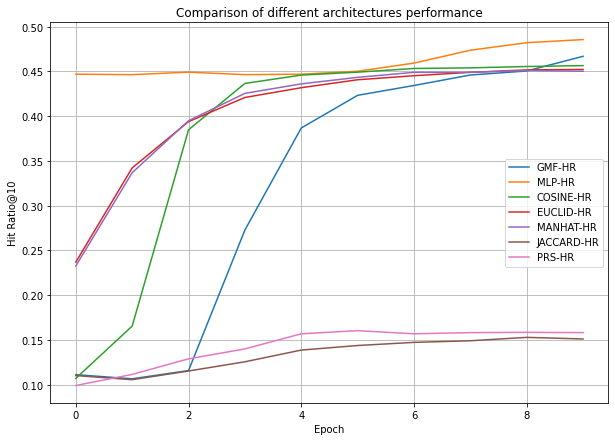

In [521]:
plt.rcParams["figure.figsize"] = (10,7)
fig, ax = plt.subplots()
ax.plot(range(len(gmf_results)), [epoch['HR'] for epoch in gmf_results], label='GMF-HR')
ax.plot(range(len(mlp_results)), [epoch['HR'] for epoch in mlp_results], label='MLP-HR')
ax.plot(range(len(cosine_results)), [epoch['HR'] for epoch in cosine_results], label='COSINE-HR')
ax.plot(range(len(euclid_results)), [epoch['HR'] for epoch in euclid_results], label='EUCLID-HR')
ax.plot(range(len(manhat_results)), [epoch['HR'] for epoch in manhat_results], label='MANHAT-HR')
ax.plot(range(len(jaccard_results)), [epoch['HR'] for epoch in jaccard_results], label='JACCARD-HR')
ax.plot(range(len(prs_results)), [epoch['HR'] for epoch in prs_results], label='PRS-HR')
#ax.plot(range(len(agg_results)), [epoch['HR'] for epoch in agg_results], label='AGG-HR')
#ax.plot(range(len(neumf_results)), [epoch['HR'] for epoch in neumf_results], label='NEUMF-HR')
#ax.plot(range(len(mlpplus_results)), [epoch['HR'] for epoch in mlpplus_results], label='MLPPLUS-HR')
#ax.plot(range(len(mlpplussim_results)), [epoch['HR'] for epoch in mlpplussim_results], label='MLPPLUSSIM-HR')
#ax.plot(range(len(mlpplussim2_results)), [epoch['HR'] for epoch in mlpplussim2_results], label='MLPPLUSSIM2-HR')


ax.set(xlabel='Epoch', ylabel='Hit Ratio@10',
       title='Comparison of different architectures performance')
ax.grid()
plt.legend()
plt.show()

In [524]:
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_mlp_100/')
dir_list.remove('.ipynb_checkpoints')
mlp_results = [{'Epoch': float(j[-3][5:]), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlp_results = sorted(mlp_results, key = lambda x: x['Epoch'])[:100]

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/mlpplussim_100/')
dir_list.remove('.ipynb_checkpoints')
mlpplussim_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
mlpplussim_results = sorted(mlpplussim_results, key = lambda x: x['Epoch'])

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_gmf_100/')
#dir_list.remove('.ipynb_checkpoints')
gmf_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
gmf_results = sorted(gmf_results, key = lambda x: x['Epoch'])

#!c1.8
dir_list = os.listdir('neural-collaborative-filtering/src/checkpoints_neumf_100/')
dir_list.remove('.ipynb_checkpoints')
neumf_results = [{'Epoch': float(j[-3][5:], ), 'HR':float(j[-2][2:]), 'NDCG':float(j[-1][4:-6])} for j in [i.split('_') for i in dir_list]]
neumf_results = sorted(neumf_results, key = lambda x: x['Epoch'])


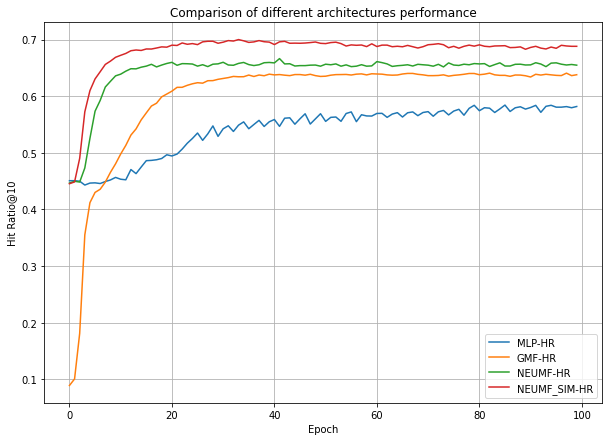

In [516]:
plt.rcParams["figure.figsize"] = (10,7)
fig, ax = plt.subplots()
ax.plot(range(len(mlp_results)), [epoch['HR'] for epoch in mlp_results], label='MLP-HR')
ax.plot(range(len(gmf_results)), [epoch['HR'] for epoch in gmf_results], label='GMF-HR')
ax.plot(range(len(neumf_results)), [epoch['HR'] for epoch in neumf_results], label='NEUMF-HR')
ax.plot(range(len(mlpplussim_results)), [epoch['HR'] for epoch in mlpplussim_results], label='NEUMF_SIM-HR')

ax.set(xlabel='Epoch', ylabel='Hit Ratio@10',
       title='Comparison of different architectures performance')
ax.grid()
plt.legend()
plt.show()

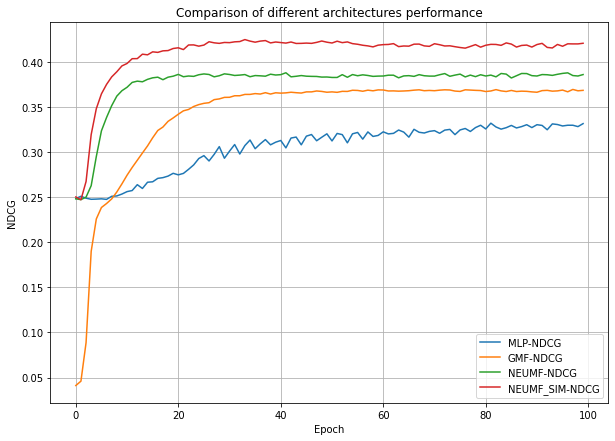

In [528]:
plt.rcParams["figure.figsize"] = (10,7)
fig, ax = plt.subplots()
ax.plot(range(len(mlp_results)), [epoch['NDCG'] for epoch in mlp_results], label='MLP-NDCG')
ax.plot(range(len(gmf_results)), [epoch['NDCG'] for epoch in gmf_results], label='GMF-NDCG')
ax.plot(range(len(neumf_results)), [epoch['NDCG'] for epoch in neumf_results], label='NEUMF-NDCG')
ax.plot(range(len(mlpplussim_results)), [epoch['NDCG'] for epoch in mlpplussim_results], label='NEUMF_SIM-NDCG')

ax.set(xlabel='Epoch', ylabel='NDCG',
       title='Comparison of different architectures performance')
ax.grid()
plt.legend()
plt.show()

In [531]:
mlp_results[-1]

{'Epoch': 35.0, 'HR': 0.5818, 'NDCG': 0.3316}

In [532]:
gmf_results[-1]

{'Epoch': 99.0, 'HR': 0.6379, 'NDCG': 0.3685}

In [533]:
neumf_results[-1]

{'Epoch': 99.0, 'HR': 0.6548, 'NDCG': 0.386}

In [529]:
mlpplussim_results[-1]

{'Epoch': 99.0, 'HR': 0.6881, 'NDCG': 0.4207}

{'Epoch': 99.0, 'HR': 0.6548, 'NDCG': 0.386}

In [69]:
#!c1.8
[epoch['HR'] for epoch in gmf_results]

In [74]:
#!c1.8
int('0.1111')

In [ ]:
#!c1.8
